## New library

In [1]:
from engine.torchengine import AnalyticalSetSympy, FunctionSympy, ParallelResiduals, EliminateAnalysis, get_analysis_structure, EliminateAnalysisMergeResiduals
from engine.torchdata import symbols, sp, generate_optim_functions, print_formatted_table
from scipy.optimize import minimize
import numpy as np
import torch

In [2]:
b = [2, 2.5, 3]
w = np.array([1.3, 1.5, 1.2])
y1e = 0.2

### Formulation

In [3]:
x1, x2, x3, y1, y2, y3, indices = symbols('x1, x2, x3, y1, y2, y3')
idxrev = {var.item():key for key,var in indices.items()}
sets = {
    0: AnalyticalSetSympy(0.1*x1*y2+0.8*x1*y3+b[0], y1, indices),
    1: AnalyticalSetSympy(x2*y3+b[1], y2, indices),
    2: AnalyticalSetSympy(0.1*x3*y1+0.8*x3*y2+b[2], y3, indices),
}
objective = FunctionSympy((y1-y1e)**2+sp.Matrix([x1**2,x2**2,x3**2]).dot(w**2), indices)

### Problem functions

In [4]:
IDF = ParallelResiduals([s.analysis for s in sets.values()], [objective])

In [5]:
order = [0,1,2]
structure_in, structure_out, full_structure = get_analysis_structure(
    [sets[idx].analysis.structure_full for idx in order])
feedback = {int(elt) for elt in structure_in}.intersection({int(elt) for elt in structure_out})
A = [elt for elt in order if len({elt.item() for elt in sets[elt].analysis.structure[1]
                                  }.intersection(feedback)) == 0]
B = [elt for elt in order if elt not in A]
R = EliminateAnalysisMergeResiduals(functions=[sets[idx].residual for idx in B])
MDFelim = EliminateAnalysis([sets[idx].analysis for idx in A], [objective, R])

In [6]:
{idxrev[elt] for elt in feedback}

{y2, y3}

In [7]:
A,B

([0], [1, 2])

### Optimization functions processed

In [8]:
x0 = torch.ones(len(indices), dtype=torch.float64)

In [9]:
prob = IDF
optim_indices = prob.structure[0]
xguess, obj_function, ineq_function, eq_function, dobj, dineq, deq, _ = generate_optim_functions(prob,
    optim_indices, x0, inequality_direction='positive-null', objective=0, residuals=1)
eqlen = len(eq_function(xguess))
constraints = [{'type': 'eq', 'fun': eq_function, 'jac': deq}] if eqlen >= 1 else []
bnds_problem = [(None, None) for elt in optim_indices]

In [10]:
obj_function(xguess), eq_function(xguess)

(12.669999999999998, tensor([1.9000, 2.5000, 2.9000], dtype=torch.float64))

In [11]:
# Solve the optimization problem
xsol = minimize(obj_function, xguess, bounds=bnds_problem, jac=dobj, 
                constraints=constraints, options={'maxiter': 500}, method='SLSQP')

In [12]:
xsol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.5698273402144947
       x: [-5.071e-01  4.750e-02  1.789e-01  2.661e+00  3.390e+00
            4.900e-01]
     nit: 10
     jac: [ 1.131e-02  2.138e-01  5.167e-01 -2.937e-02 -2.349e-01
            0.000e+00]
    nfev: 12
    njev: 10

In [13]:
print_formatted_table([x0], indices, idxrev)

x1     x2    x3    y1   y2    y3  
-0.507 0.047 0.179 0.49 2.661 3.39


## Old library

In [14]:
from modeling.api import Var
from modeling.couplingapi import Subproblem, intersection, problem

### Formulation

In [15]:
x1, x2, x3, y2, y3  = Var('x_1'), Var('x_2'), Var('x_3'), Var('y_2'), Var('y_3')
a1 = Subproblem()
y1 = a1.Var('y_1', 0.1*x1*y2+0.8*x1*y3+b[0])
a2 = Subproblem()
a2.add_equation(y2, x2*y3+b[1])
a3 = Subproblem()
a3.add_equation(y3, 0.1*x3*y1+0.8*x3*y2+b[2])
objective = (y1-y1e)**2+sp.Matrix([x1**2,x2**2,x3**2]).dot(w**2)

### Problem functions

In [25]:
merged_discipline = intersection(a1, a2, a3, mergesets=True)
P = problem(objective, [], [merged_discipline], counter=1)

In [26]:
merged_discipline.Ftree

OrderedDict([(0, 3), (1, 3), (2, 3)])

### Problem structure

In [17]:
from modeling.execution import edges_from_components
from collections import OrderedDict
def reorder(Ftree, order):
    d = OrderedDict()
    for elt in order:
        d[elt] = Ftree[elt]
    for key,var in Ftree.items():
        if key not in d:
            d[key]=var
    return d

In [18]:
edges = edges_from_components(P.components)
order = [3,1,2]
tree = reorder(P.Ftree,order), P.Stree, {'x_1': 1, 'x_2':1, 'x_3': 1}

In [19]:
edges, tree

(({1: ('y_3', 'y_2', 'x_1'),
   2: ('x_2', 'y_3'),
   3: ('y_1', 'x_3', 'y_2'),
   4: ('y_1', 'x_3', 'x_2', 'x_1')},
  {1: ('y_1',), 2: ('y_2',), 3: ('y_3',), 4: (None,)},
  {}),
 (OrderedDict([(3, 2), (1, 0), (2, 1), (4, 4)]),
  {3: 4, 0: 3, 1: 3, 2: 3},
  {'x_1': 1, 'x_2': 1, 'x_3': 1}))

### Optimizer functions

In [81]:
from modeling.couplingapi import get_vals
from solver.runpipeline import run_valid_formulation
from graph.graphutils import VAR, COMP, SOLVER

In [22]:
solver_options = P.solver_options
solver_options[1].update({'optimizer': 'L-BFGS-B', 'maxiter': 75})
solver_options[2] = {'solver': 'GS', 'maxiter':20}
comp_options = P.comp_options
var_options = {}
nametyperepr = {VAR: '{}', COMP: 'f{}', SOLVER: 's{}'}
prob, mdao_in, groups = run_valid_formulation(edges, tree, P.components, solver_options, comp_options, var_options, nametyperepr)
P.prob = prob

KeyError: 1

In [17]:
out = get_vals(P, independent_only=False)

In [18]:
out

{y_1: array([1.]),
 y_2: array([1.]),
 y_3: array([1.]),
 x_1: array([0.22199317]),
 x_2: array([0.20671916]),
 x_3: array([0.87073231])}

In [19]:
prob.run_model()


==
s2
==
NL: NLBGS Converged in 15 iterations


In [20]:
out = get_vals(P, independent_only=False)

In [21]:
P.solve_with_engine(out, save_projected=True)


==
s2
==
NL: NLBGS Converged in 1 iterations


{y_1: array([3.12249299]), y_2: array([3.71069235]), y_3: array([5.85670132])}

In [22]:
solver = prob.model.s2.nonlinear_solver
recorder = om.SqliteRecorder("cases.sqlite")
solver.add_recorder(recorder)
prob.setup();

In [23]:
out_opt = P.solve_with_engine(save_projected=True, optimize=True)


==
s2
==
NL: NLBGS Converged in 1 iterations

==
s2
==
NL: NLBGS Converged in 1 iterations

==
s2
==
NL: NLBGSSolver 'NL: NLBGS' on system 's2' failed to converge in 20 iterations.

==
s2
==
NL: NLBGS Converged in 12 iterations

==
s2
==
NL: NLBGS Converged in 9 iterations

==
s2
==
NL: NLBGS Converged in 12 iterations

==
s2
==
NL: NLBGS Converged in 11 iterations

==
s2
==
NL: NLBGS Converged in 10 iterations

==
s2
==
NL: NLBGS Converged in 9 iterations

==
s2
==
NL: NLBGS Converged in 7 iterations

==
s2
==
NL: NLBGS Converged in 6 iterations

==
s2
==
NL: NLBGS Converged in 6 iterations

==
s2
==
NL: NLBGS Converged in 6 iterations

==
s2
==
NL: NLBGS Converged in 5 iterations

==
s2
==
NL: NLBGS Converged in 5 iterations

==
s2
==
NL: NLBGS Converged in 5 iterations

==
s2
==
NL: NLBGS Converged in 5 iterations

==
s2
==
NL: NLBGS Converged in 5 iterations
Optimization Complete
-----------------------------------


In [24]:
prob.cleanup();
cr = om.CaseReader("cases.sqlite")
solver_cases = cr.list_cases(out_stream=None);

import matplotlib.pyplot as plt

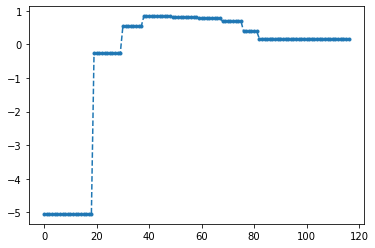

In [25]:
plt.plot([cr.get_case(elt).get_val('x_3') for elt in solver_cases], '.--');

In [26]:
get_vals(P, independent_only=False)

{y_1: array([0.4684394]),
 y_2: array([2.55942594]),
 y_3: array([3.35619869]),
 x_1: array([-0.52077928]),
 x_2: array([0.01770632]),
 x_3: array([0.17007319])}

In [27]:
prob.list_problem_vars()

----------------
Design Variables
----------------
name  val            size  
----  -------------  ---- 
x_1   [-0.52077928]  1     
x_2   [0.01770632]   1     
x_3   [0.17007319]   1     

-----------
Constraints
-----------
name  val  size  
----  ---  ---- 

----------
Objectives
----------
name  val           size  
----  ------------  ---- 
obj4  [0.57276366]  1     



# Plotting the structures

In [15]:
edges

({1: ('y_2', 'x_1', 'y_3'),
  2: ('x_2', 'y_3'),
  3: ('x_3', 'y_1', 'y_2'),
  4: ('x_3', 'x_2', 'y_1', 'x_1')},
 {1: ('y_1',), 2: ('y_2',), 3: ('y_3',), 4: (None,)},
 {})

In [16]:
from graph.graphutils import flat_graph_formulation, draw_graph_graphical_props, Node
from graph.nestedgraph import merge_graph

In [17]:
nodetyperepr = {VAR: '{}', COMP: 'a_{}', SOLVER: 'P_{}'}
#Ein = filter_comps(edges[0], [1,2])
#Eout = filter_comps(edges[1], [1,2])
G = flat_graph_formulation(*edges, nodetyperepr=nodetyperepr)

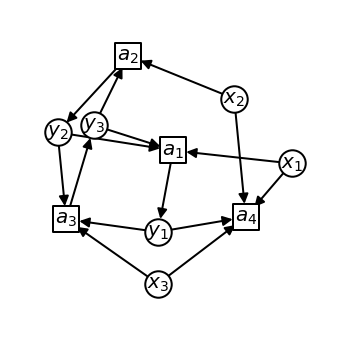

In [18]:
draw_graph_graphical_props(G, prog='neato', figsize=(6,6));

In [19]:
merge1 = {Node(1, COMP), Node(3, COMP)}
merge2 = {Node(2, COMP)}

In [20]:
G_merge, G_sub1 = merge_graph(G, merge1, set(), solver_idx=1, nodetyperepr=nodetyperepr, exclude_unique_sources=False)
G_merge, G_sub2 = merge_graph(G_merge, merge2, set(), solver_idx=2, nodetyperepr=nodetyperepr, exclude_unique_sources=False)

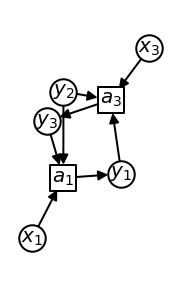

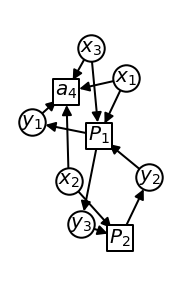

In [21]:
draw_graph_graphical_props(G_sub1, figsize=(3,5));
draw_graph_graphical_props(G_merge, figsize=(3,5))

In [63]:
prob, mdao_in, groups = run_valid_formulation(edges, rtree, P.components, solver_options, comp_options, var_options, nametyperepr)

In [54]:
ordered_tree = rtree
ordered_edges = edges
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
solvers_options[1].update({'optimizer': 'L-BFGS-B', 'maxiter': 75})
solvers_options[2] = {'solver': 'GS', 'maxiter':20}
nodetyperepr = model.nametyperepr
namingfunc = namefromid(nodetyperepr)
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [24]:
P.components

[(('y_2', 'x_1', 'y_3'), 1, ('y_1',), '0.1*x_1*y_2 + 0.8*x_1*y_3 + 2'),
 (('x_2', 'y_3'), 2, ('y_2',), 'x_2*y_3 + 2.5'),
 (('x_3', 'y_1', 'y_2'), 3, ('y_3',), '0.1*x_3*y_1 + 0.8*x_3*y_2 + 3'),
 (('x_3', 'x_2', 'y_1', 'x_1'), 4, (None,), '1.69*x_1**2 + 2.25*x_2**2 + 1.44*x_3**2 + (y_1 - 0.2)**2')]

In [64]:
model.components

[(('a2', 'x1', 'a3'), 0, ('a1',), '0.1*a2*x1 + 0.8*a3*x1 + 2'),
 (('x2', 'a3'), 1, ('a2',), 'a3*x2 + 2.5'),
 (('x3', 'a1', 'a2'), 2, ('a3',), '0.1*a1*x3 + 0.8*a2*x3 + 3'),
 (('x3', 'x2', 'a1', 'x1'), 3, (None,), '1.69*x1**2 + 2.25*x2**2 + 1.44*x3**2 + (a1 - 0.2)**2')]

In [56]:
components = model.components
all_components = generate_components_and_residuals(components, ordered_edges)

In [57]:
all_components

[(('a2', 'x1', 'a3'), 0, ('a1',), '0.1*a2*x1 + 0.8*a3*x1 + 2'),
 (('x2', 'a3'), 1, ('a2',), 'a3*x2 + 2.5'),
 (('x3', 'a1', 'a2'), 2, ('a3',), '0.1*a1*x3 + 0.8*a2*x3 + 3'),
 (('x3', 'x2', 'a1', 'x1'), 3, (None,), '1.69*x1**2 + 2.25*x2**2 + 1.44*x3**2 + (a1 - 0.2)**2')]

In [58]:
lookup_f = get_f(all_components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc)

In [59]:
recorder = om.SqliteRecorder("cases.sqlite")
solver = prob.model.s2.nonlinear_solver
solver.add_recorder(recorder)
#solver.recording_options['includes'] = ['*']
#solver.recording_options['record_outputs'] = True
#solver.options['use_apply_nonlinear'] = True

In [60]:
#prob.model.s1.f3.add_recorder(recorder)

In [61]:
for key,val in ordered_tree[0].items():
    s = groups[namingfunc(val, SOLVER)]
    f = getattr(s, namingfunc(key, COMP))
    f.recording_options['options_excludes'] = ['component']

In [62]:
#prob.setup();

In [63]:
prob.run_driver();


==
s2
==
NL: NLBGS Converged in 14 iterations

==
s2
==
NL: NLBGS Converged in 1 iterations

==
s2
==
NL: NLBGSSolver 'NL: NLBGS' on system 's2' failed to converge in 20 iterations.

==
s2
==
NL: NLBGS Converged in 14 iterations
Optimization Complete
-----------------------------------


In [24]:
prob.cleanup();
cr = om.CaseReader("cases.sqlite")
solver_cases = cr.list_cases(out_stream=None);

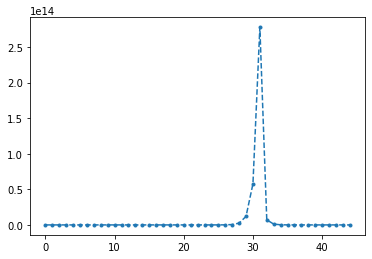

In [25]:
plt.plot([cr.get_case(elt).get_val('a3') for elt in solver_cases], '.--');

In [44]:
last_case = cr.get_case(solver_cases[1])

In [27]:
last_case.list_outputs();

4 Explicit Output(s) in 's1'

varname  val         
-------  ------------
s2
  f1
    a2   [6.11164591]
  f2
    a3   [4.14782579]
  f0
    a1   [2.81228746]
f3
  obj3   [8.67312201]


0 Implicit Output(s) in 's1'




In [54]:
prob.model.list_outputs();

7 Explicit Output(s) in 'model'

varname   val          
--------  -------------
inp
  x1      [-0.50713742]
  x3      [0.17880901] 
  x2      [0.0474264]  
s1
  s2
    f0
      a1  [0.48996124] 
    f1
      a2  [2.66074577] 
    f2
      a3  [3.3893732]  
  f3
    obj3  [0.56982733] 


0 Implicit Output(s) in 'model'




In [52]:
prob.model.s2.iter_count_apply

87